# Spectrographs (not working at present)


In [29]:
from IPython.html.widgets import (
    FlexBox, VBox, HBox, HTML, Box, RadioButtons,
    FloatText, Dropdown, Checkbox, Image, IntSlider, Button,
)
from IPython.utils.traitlets import (
    link, Unicode, Float, Int, Enum, Bool,
)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


Use [`OrderedDict`](https://docs.python.org/2/library/collections.html#collections.OrderedDict) for predictable display of key-value pairs.

In [30]:
from collections import OrderedDict

CSS helps keep your code concise, as well as make it easier to extend/override.

In [31]:
%%html
<style>
/*
    This contents of this would go in a separate CSS file.

    Note the namespacing: this is important for two reasons.
    1) doesn't pollute the global namespace
    2) is _more specific_ than the base styles.
*/

.widget-area .spectroscopy .panel-body{
    padding: 0;
}
.widget-area .spectroscopy .widget-numeric-text{
    width: 5em;
}
.widget-area .spectroscopy .widget-box.start{
    margin-left: 0;
}
.widget-area .spectroscopy .widget-hslider{
    width: 12em;
}
    
</style>

These few classes wrap up some [Bootstrap components](http://getbootstrap.com/components/): these will be more consistent then coding up your own.

In [32]:
class PanelTitle(HTML):
    def __init__(self, *args, **kwargs):
        super(PanelTitle, self).__init__(*args, **kwargs)
        self.on_displayed(self.displayed)
    def displayed(self, _):
        pass
        self.add_class("panel-heading panel-title")

class PanelBody(Box):
    def __init__(self, *args, **kwargs):
        super(PanelBody, self).__init__(*args, **kwargs)
        self.on_displayed(self.displayed)
    def displayed(self, _):
        pass
        self.add_class("panel-body")

class ControlPanel(Box):
    # A set of related controls, with an optional title, in a box (provided by CSS)
    def __init__(self, title=None, *args, **kwargs):
        super(ControlPanel, self).__init__(*args, **kwargs)
        
        # add an option title widget
        if title is not None:
            
            self.children = [
                PanelTitle(value=title),
                PanelBody(children=self.children)
            ]

        self.on_displayed(self.displayed)
    
    def displayed(self, _):
        pass
        self.add_class("panel panel-info")

This notional `Spectrogram` shows how one might make a widget that redraws based on the state of its data. By defining its external API, including allowed and default values, in the form of [linked traitlets](http://ipython.org/ipython-doc/dev/api/generated/IPython.utils.traitlets.html#IPython.utils.traitlets.link), it can be reused without replumbing any events, while a few simple methods like `draw` make sure it is still easy to use in a programmatic way.

In [33]:
import re
from datetime import datetime

class Spectrogram(HTML):
    """
    A notional "complex widget" that knows how to redraw itself when key properties change.
    """
    # Utility
    DONT_DRAW = re.compile(r'^(_.+|value|keys|comm|children|visible|parent|log|config|msg_throttle)$')
    
    # Lookup tables: this would be a nice place to add i18n, perhaps
    CORRELATION = OrderedDict([(x, x) for x in ["synchronous", "asynchronous", "modulus", "argument"]])    
    DRAW_MODE = OrderedDict([(x, x) for x in ["color", "black & white", "contour"]])    
    SPECTRUM_SCALE = OrderedDict([(x, x) for x in ["auto", "manual"]])
    SPECTRUM_DIRECTIONS = OrderedDict([(x, x) for x in ["left", "right", "bottom", "top"]])
    
    # pass-through traitlets
    correlation = Enum(CORRELATION.values(), default_value=CORRELATION.values()[0], sync=True)
    draw_mode = Enum(DRAW_MODE.values(), default_value=DRAW_MODE.values()[0], sync=True)
    
    spectrum_direction_left = Float(1000, sync=True)
    spectrum_direction_right = Float(1000, sync=True)
    spectrum_direction_bottom = Float(1000, sync=True)
    spectrum_direction_top = Float(1000, sync=True)
    
    spectrum_contours = Int(4, sync=True)
    spectrum_zmax = Float(0.0566468618, sync=True)
    spectrum_scale = Enum(SPECTRUM_SCALE, default_value=SPECTRUM_SCALE.values()[0], sync=True)

    axis_x = Float(50, sync=True)
    axis_y = Float(50, sync=True)
    axis_display = Bool(True, sync=True)
    
    def __init__(self, *args, **kwargs):
        """
        Creates a spectrogram
        """
        super(Spectrogram, self).__init__(*args, **kwargs)
        self.on_trait_change(lambda name, old, new: self.draw(name, old, new))
        self.on_displayed(self.displayed)

    def displayed(self, _):
        self.add_class("col-xs-9")
        self.draw()
    
    def draw(self, name=None, old=None, new=None):
        if name is not None and self.DONT_DRAW.match(name):
            return
        
        value = "<h2>Imagine a picture here, drawn with...</h2>"

        if name is None:
            value += '<div class="alert alert-info">redraw forced at %s!</div>' % (
                datetime.now().isoformat(' ')
            )
        
        value += "\n".join([
            '<p><span class="label label-%s">%s</span> %s</p>' % (
                'success' if traitlet == name else 'default',
                traitlet,
                getattr(self, traitlet)
            )
            for traitlet in sorted(self.trait_names())
            if not self.DONT_DRAW.match(traitlet)
        ])
        self.value = value

The actual GUI. Note that the individual components of the view are responsible for:
- creating widgets
- linking to the graph widget

In [34]:
class Spectroscopy(Box):
    """
    An example GUI for a spectroscopy application.
    
    Note that `self.graph` is the owner of all of the "real" data, while this
    class handles creating all of the GUI controls and links. This ensures
    that the Graph itself remains embeddable and rem
    """
    def __init__(self, graph=None, graph_config=None, *args, **kwargs):
        self.graph = graph or Spectrogram(**(graph_config or {}))
        # Create a GUI
        kwargs["orientation"] = 'horizontal'
        kwargs["children"] = [
            self._controls(),
            VBox(children=[
                self._actions(),
                self.graph
            ])
        ]
        super(Spectroscopy, self).__init__(*args, **kwargs)
        
        self.on_displayed(self.displayed)

    def displayed(self, _):
        pass
        # namespace and top-level bootstrap
        self.add_class("spectroscopy row")
    
    def _actions(self):
        redraw = Button(description="Redraw")
        redraw.on_click(lambda x: self.graph.draw())
        return HBox(children=[redraw])
    
    def _controls(self):
        panels = VBox(children=[
            HBox(children=[
                self._correlation(),
                self._draw_mode(),
            ]),
            self._spectrum(),
            self._axes()
        ])
        panels.on_displayed(lambda x: panels.add_class("col-xs-3"))
        return panels
    
    def _correlation(self):
        # create correlation controls. NOTE: should only be called once.
        radios = RadioButtons(values=self.graph.CORRELATION)
        link((self.graph, "correlation"), (radios, "value"))
        return ControlPanel(title="correlation", children=[radios])

    def _draw_mode(self):
        # create draw mode controls.  NOTE: should only be called once.
        radios = RadioButtons(values=self.graph.DRAW_MODE)
        link((self.graph, "draw_mode"), (radios, "value"))
        return ControlPanel(title="draw", children=[radios])

    def _spectrum(self):
        # create spectrum controls.  NOTE: should only be called once.
        directions = []
        
        for label in self.graph.SPECTRUM_DIRECTIONS:
            direction = FloatText(description=label, value=1000.0)
            link((self.graph, "spectrum_direction_" + label), (direction, "value"))
            directions.append(direction)
        
        direction_rows = [HBox(children=directions[x::2]) for x in range(2)]
        
        contour = IntSlider(description="contours", min=1)
        link((self.graph, "spectrum_contours"), (contour, "value"))

        zmax = FloatText(description="z-max")
        link((self.graph, "spectrum_zmax"), (zmax, "value"))
        
        scale = RadioButtons(description="scale", values=self.graph.SPECTRUM_SCALE)
        link((self.graph, "spectrum_scale"), (scale, "value"))
        
        return ControlPanel(title="spectrum",
            children=direction_rows + [
                contour,
                zmax,
                scale
            ]
        )
    
    def _axes(self):
        # create spectrum controls.  NOTE: should only be called once.
        axis_x = FloatText(description="X div.")
        link((self.graph, "axis_x"), (axis_x, "value"))
        
        axis_y = FloatText(description="Y div.")
        link((self.graph, "axis_y"), (axis_y, "value"))
        
        axes = HBox(children=[axis_x, axis_y])

        axis_display = Checkbox(description="display")
        link((self.graph, "axis_display"), (axis_display, "value"))
        
        return ControlPanel(title="axes",
            children=[
                axis_display,
                axes
            ]
        )

Hooray, everything is defined, now we can try this out!

In [35]:
spectrogram = Spectrogram()
spectrogram

AttributeError: 'Spectrogram' object has no attribute 'add_class'

Its traits can be updated directly, causing immediate update:

In [36]:
spectrogram.axis_display = False

The graph can be passed directly to the interactive GUI, sharing the same data between the two views.

In [37]:
gui = Spectroscopy(graph=spectrogram)
gui

KeyError: 'synchronous'

#Diverse topics

In [38]:
word = 'exponentialb'
if word in ['exp','exponential']:
    print('in')

In [39]:
a = True
print(a)
a &= True
print(a)
a &= False
print(a)



True
True
False


In [48]:
import numpy as np

def getA(sampleSize):
    if type(sampleSize) is int:
        out = np.zeros((sampleSize, sampleSize))
    elif type(sampleSize) is list or type(sampleSize) is tuple:
        out = np.zeros(sampleSize)
    else:
        out = np.zeros(0)
    return out


# sshape = 0
# out = np.array(sshape)
# out[...] = 5
# print(out.shape, out, out[()])

print(getA(None))
print(getA(5))
print(getA([1, 1e5]))
print(getA([1e5, 1]))




[]
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.]
 [ 0.]
 [ 0.]
 ..., 
 [ 0.]
 [ 0.]
 [ 0.]]


In [51]:
import numpy as np
import h5py
f = h5py.File('data/ccd.hd5')
print(f)
# ccd = f['ccd']

<HDF5 file "ccd.hd5" (mode r+)>


In [52]:
# aa = f['ccd/value/A_ADC/'].attrs

# aa = [(name, val) for name, val in f['ccd/value/A_ADC/value'].attrs.iteritems()]
# aa = f['ccd/value/A_ADC/value'].value

print(f['ccd/value/illumination/value/amplitude_coeff/value'].value)
ds = f['ccd/value/illumination/value/amplitude_coeff/value']
print(type(ds))
ds[...] = 5
print(f['ccd/value/illumination/value/amplitude_coeff/value'].value)
f['ccd/value/illumination/value/amplitude_coeff/value'][...] = 10
print(f['ccd/value/illumination/value/amplitude_coeff/value'].value)


10.0
<class 'h5py._hl.dataset.Dataset'>
5.0
10.0


In [58]:
# def printname(name):
#     print(name)
# f.visit(printname)  


# def printdatasetpaths(value, obj):
#     if value[-5:]=='value' and type(obj.file[value]) is h5py._hl.dataset.Dataset:
#         print(value)
# f.visititems(printdatasetpaths)    

# def printdatasetvalue(value, obj):
#     aa = obj.file[value] 
#     if value[-5:]=='value' and type(aa) is h5py._hl.dataset.Dataset:
#         print(value, aa.value)
# f.visititems(printdatasetvalue)    

datasetlist = []
mylist = []
f.visit(mylist.append)
for value in mylist:
    if value[-5:]=='value' and type(f[value]) is h5py._hl.dataset.Dataset:
        if value not in datasetlist:
            datasetlist.append(value)
datasetlist
with open('ccd-datasets.txt','wt') as fo:
    for value in datasetlist:
        fo.write('{}\n'.format(value))

# print(mylist)
print(datasetlist)

[u'ccd/value/A_ADC/value', u'ccd/value/A_CDS/value', u'ccd/value/A_SF/value', u'ccd/value/A_SN/value', u'ccd/value/Boltzman_Constant/value', u'ccd/value/Boltzman_Constant_JK/value', u'ccd/value/C_SN/value', u'ccd/value/DARK_e/value', u'ccd/value/DFM/value', u'ccd/value/Eg/value', u'ccd/value/Eg_0/value', u'ccd/value/FW_e/value', u'ccd/value/FillFactor/value', u'ccd/value/N_bits/value', u'ccd/value/QE_I/value', u'ccd/value/QuantumYield/value', u'ccd/value/S_ADC_OFFSET/value', u'ccd/value/SensorType/value', u'ccd/value/Signal_CCD_DN/value', u'ccd/value/Signal_CCD_electrons/value', u'ccd/value/Signal_CCD_photons/value', u'ccd/value/Signal_CCD_voltage/value', u'ccd/value/T/value', u'ccd/value/V_FW/value', u'ccd/value/V_REF/value', u'ccd/value/V_min/value', u'ccd/value/alpha/value', u'ccd/value/beta/value', u'ccd/value/c/value', u'ccd/value/dark_signal/value', u'ccd/value/flag/value/ADCnonlinearity/value', u'ccd/value/flag/value/PRNU/value', u'ccd/value/flag/value/VVnonlinearity/value', u'c

In [60]:
print(ccd['value'].keys()[0])
for item in ccd['value'].keys():
    print(ccd['value'][item])
    for ii in ccd['value'][item].keys():
        print(ccd['value'][item][ii])
#         print(ccd['value'][item][ii].value)
        if len(ccd['value'][item][ii].keys()) > 0:
            for ij in ccd['value'][item][ii].keys():
                print(ccd['value'][item][ii][ij])

# print(f['/ccd/value/A_ADC/value'])
# print(f['/ccd/value/A_ADC/type'])


KeyError: "Unable to open object (Object 'value' doesn't exist)"

#Read Matlab mat file with scipy

In [11]:
import scipy.io as sio
sio.whosmat('data/ccd-simple.mat')

[('ccd', (1, 1), 'struct'),
 ('m', (1, 1), 'double'),
 ('cm', (1, 1), 'double'),
 ('mm', (1, 1), 'double'),
 ('mum', (1, 1), 'double'),
 ('nm', (1, 1), 'double'),
 ('rad', (1, 1), 'double'),
 ('mrad', (1, 1), 'double'),
 ('N', (1, 1), 'double'),
 ('M', (1, 1), 'double'),
 ('Uin', (256, 256), 'double')]

In [16]:
import scipy.io as sio
mat_contents = sio.loadmat('data/ccd-simple.mat')
# mat_contents

[[152 152 152 ..., 105 105 103]
 [153 154 154 ..., 107 107 107]
 [154 155 155 ..., 109 108 106]
 ..., 
 [149 144 139 ...,  40  40  41]
 [152 144 129 ...,  37  37  37]
 [156 150 130 ...,  42  40  39]]


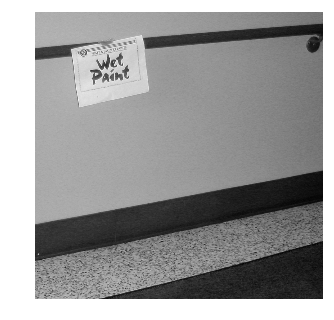

In [17]:
# http://stackoverflow.com/questions/874461/read-mat-files-in-python
import scipy.io as sio
import pyradi.ryplot as ryplot
%matplotlib inline

sio.whosmat('images/paint.mat')
paint = sio.loadmat('images/paint.mat')
print(paint['paint'])

p = ryplot.Plotter(1,1,3,figsize=(18,6))
p.showImage(1, paint['paint'].astype(float));


#Diverse play

In [19]:
print('{:.9e}'.format( 10.909 * 10 ** (- 15)   )  )


1.090900000e-14


In [20]:
import numpy as np
np.log10(0+np.finfo(float).eps)

-15.653559774527022

In [21]:
import numpy as np
a = np.asarray([0, 1, 2, 3, 4, 5])
b = 5 + a
c = 10 + b
d = 100 + c 

print(np.max(a))
print(np.max(b))
print(np.max([a, b, c, d]))


5
10
120


In [22]:
print(np.log(1.7976931348623157e308))
print(np.exp(709.7))

709.782712893
1.65498402768e+308


In [23]:
def fn(e):
    return np.exp(e * (e<709.7))

print(np.where(b<6, fn(100 * b), 0))

[  1.40359222e+217   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


In [24]:
# from sympy import *
import sympy
sympy.init_printing()
e0 = sympy.Symbol('e0')
e1 = sympy.Symbol('e1')
a = e1 ** 2 * (1- e0) - e0 ** 2 * (1 - e1) + \
     (e1**2-e0**2)*(1-e0) *(1-e1)/ (1-(1-e0)*(1-e1))
b = a.simplify()
print((sympy.latex(b)))

\frac{1}{e_{0} e_{1} - e_{0} - e_{1}} \left(e_{0}^{3} e_{1}^{2} - e_{0}^{3} e_{1} - e_{0}^{2} e_{1}^{3} + e_{0}^{2} + e_{0} e_{1}^{3} - e_{1}^{2}\right)


In [25]:
def myFunc(a=5, b=2):
    """Very powerful function returns a**b
    """
    c = 5
    d = 'string'
    return a ** b

myFunc.e = 20

print(myFunc(4,2))

print(type(myFunc))
print(myFunc.func_name)
print(myFunc.func_dict)
print(myFunc.__dict__)
print(myFunc.func_defaults)
print(myFunc.func_doc)
print(myFunc.func_code.co_varnames)

16
<type 'function'>
myFunc
{'e': 20}
{'e': 20}
(5, 2)
Very powerful function returns a**b
    
('a', 'b', 'c', 'd')


In [26]:
print(5/2)
a = [1, 2, 3]
b=a
b[0]=4
print(a)
print(b)


2
[4, 2, 3]
[4, 2, 3]


In [27]:
import numpy as np
f3 = 1.6
f2 = 1.5
f1 = 1.475
r=2

p = np.log((f3-f2)/(f2-f1)) / np.log(r)
print(p)
    


2.0


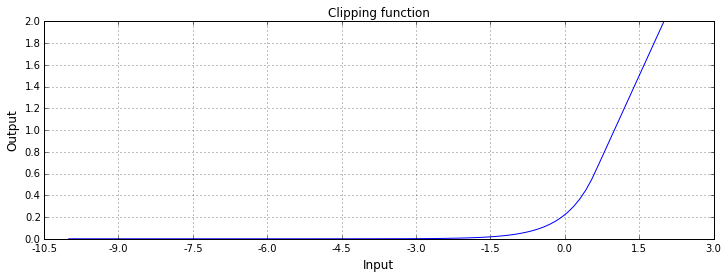

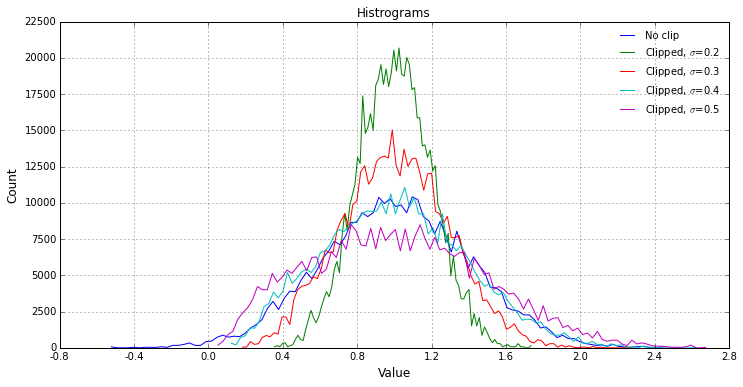

In [28]:
import numpy as np
import pyradi.ryplot as ryplot
from scipy.stats import norm
%matplotlib inline

def limitzero(a, thr=0.6):
    return   (np.where(a<thr,thr * np.exp((a-thr)/(1*thr)),0)+np.where(a>=thr, a,0))

thres = 0.6
rv = norm.rvs(loc=1, scale=0.4, size=10000)
hist, bins = np.histogram(rv, bins=100)

a = np.linspace(-10, 2, 100)
p = ryplot.Plotter(1,1,1,figsize=(12,4))
p.plot(1,a,limitzero(a, thres),'Clipping function','Input','Output')

q = ryplot.Plotter(2,1,1,figsize=(12,6))
q.plot(1,(bins[1:]+bins[:-1])/2.,hist /(bins[1]-bins[0]),'Histrograms','Value','Count',label=['No clip'])
for sigma in [0.2, 0.3, 0.4, 0.5]:
# for sigma in [0.1]:
    rv = norm.rvs(loc=1, scale=sigma, size=10000)
    histl, binsl = np.histogram(limitzero(rv,thres), bins=100)
    q.plot(1,(binsl[1:]+binsl[:-1])/2.,histl/(binsl[1]-binsl[0]),label=['Clipped, $\sigma$={}'.format(sigma)])

Create lognormal variables centred around zero

(-0.035954878263516843, 0.0279438578145349, -1.2866826943563618)


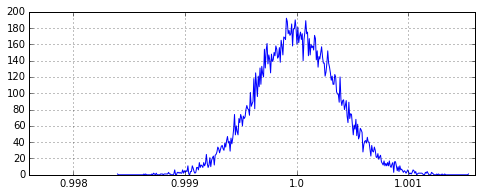

In [18]:
import numpy as np
import pyradi.ryplot as ryplot
%matplotlib inline

numb = 20000
sigma = 0.00035952744787
rn = np.random.standard_normal((numb,))
rne = np.exp(sigma * rn) 
rnem1 = np.exp(sigma * rn) - 1

p = ryplot.Plotter(1,1,1,figsize=(8,3))
hst, bins = np.histogram(rn,bins=400,density=False)
binc = (bins[1:]+bins[:-1])/2
# p.plot(1, binc, hst,'','','', maxNX=5);
hste, binse = np.histogram(rne,bins=400,density=False)
binse = (binse[1:]+binse[:-1])/2
p.plot(1, binse, hste,'','','', maxNX=5);
hstem1, binsem1 = np.histogram(rnem1,bins=400,density=False)
binsem1 = (binsem1[1:]+binsem1[:-1])/2
# p.plot(1, binsem1, hstem1,'','','', maxNX=5);

print(np.sum(rnem1[:numb/2]), np.sum(rnem1[numb/2:-1]), np.sum(rnem1[:numb/2])/np.sum(rnem1[numb/2:-1]))